In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

import tensorflow_utils as tf_utils

random_seed = 123
sess = tf.Session()

In [2]:
def generate_data(num_mode, except_num, radius=2, center=(0, 0), sigma=0.1, num_data_per_class=100000, name=None):
    total_data = {}
    
    t = np.linspace(0, 2*np.pi, 13)
    x = np.cos(t) * radius + center[0]
    y = np.sin(t) * radius + center[1]
    
    # draw two circles-like lines
    plt.figure()
    plt.plot(x, y)
    
    modes = np.vstack([x, y]).T
    
    for idx, mode in enumerate(modes[except_num:]):
        x = np.random.normal(mode[0], sigma, num_data_per_class)
        y = np.random.normal(mode[1], sigma, num_data_per_class)
        total_data[idx] = np.vstack([x, y]).T
        plt.plot(x, y)
        
    all_points = np.vstack([values for values in total_data.values()])
    data_x, data_y = all_points[:, 0], all_points[:, 1]
    
    plt.savefig('{}.png'.format(name, bbox_inches='tight'))
    
    return total_data, all_points

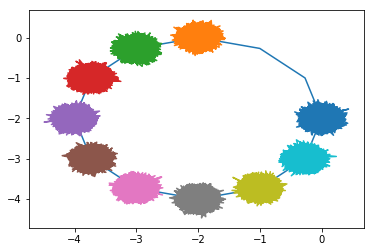

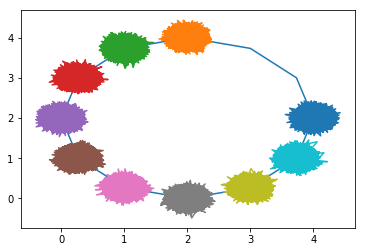

In [3]:
A_data_with_class, A_data = generate_data(13, 3, radius=2, center=(-2, -2), name='A_data')
B_data_with_class, B_data = generate_data(13, 3, radius=2, center=(2, 2), name='B_data')

A_train_np, A_test_np = train_test_split(A_data, test_size=0.33, random_state=random_seed)
B_train_np, B_test_np = train_test_split(B_data, test_size=0.33, random_state=random_seed)

A_train_np, A_test_np = A_train_np.astype(np.float32), A_test_np.astype(np.float32)
B_train_np, B_test_np = B_train_np.astype(np.float32), B_test_np.astype(np.float32)

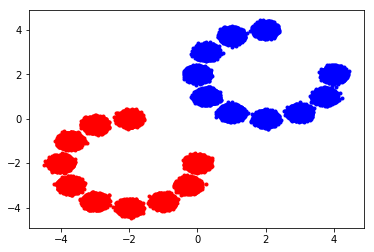

In [4]:
def plot(data, color):
    plt.plot(data[:, 0], data[:, 1], color)
    
plt.figure()
plot(A_data, 'r.')  # (-2, -2)
plot(B_data, 'b.')  # (2, 2)
plt.savefig('two_modes.png', bbox_inches='tight')

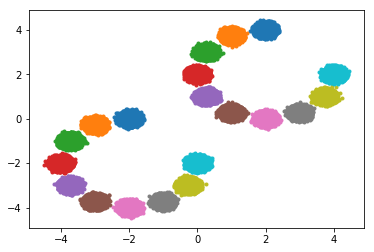

In [5]:
def plot_with_class(data_with_class):
    for key, value in data_with_class.items():
        plot(value, '.')

plt.figure()
plot_with_class(A_data_with_class)  # (-2, -2)
plot_with_class(B_data_with_class)  # (2, 2)
plt.savefig('two_modes_with_class', bbox_inches='tight')

In [6]:
print('A_train_np shape: {}'.format(A_train_np.shape))
print('A_test_np shape: {}'.format(A_test_np.shape))
print('B_train_np shape: {}'.format(B_train_np.shape))
print('B_test_np shape: {}'.format(B_test_np.shape))

print('A_train_np dtype: {}'.format(A_train_np.dtype))
print('A_test_np dtype: {}'.format(A_test_np.dtype))
print('B_train_np dtype: {}'.format(B_train_np.dtype))
print('B_test_np dtype: {}'.format(B_test_np.dtype))

A_train_np shape: (670000, 2)
A_test_np shape: (330000, 2)
B_train_np shape: (670000, 2)
B_test_np shape: (330000, 2)
A_train_np dtype: float32
A_test_np dtype: float32
B_train_np dtype: float32
B_test_np dtype: float32


In [7]:
# dataset loader
batch_size = 200

class DataLoader:
    def __init__(self, data):
        self.data = data
        
    def next_batch(self, batch_size=4):
        random_idx = np.random.randint(self.data.shape[0], size=batch_size)
        batch_data = self.data[random_idx, :]
        return batch_data

A_train_loader = DataLoader(A_train_np)
A_test_loader = DataLoader(A_test_np)

B_train_loader = DataLoader(B_train_np)
B_test_loader = DataLoader(B_test_np)

In [8]:
class Generator(object):
    def __init__(self, name, output_size, hidden_dims):
        self.name = name
        self.output_size = output_size
        self.hidden_dims = hidden_dims
        self.reuse = False
        
    def __call__(self, x):
        with tf.variable_scope(self.name, reuse=self.reuse):
            tf_utils.print_activations(x)
            
            input_data = x
            for idx, hidden_dim in enumerate(self.hidden_dims):
                output = tf_utils.linear(input_data, hidden_dim, name='fc_{}'.format(idx))
                output = tf_utils.relu(output, name='relu_{}'.format(idx))
                input_data = output
                
            output = tf_utils.linear(output, self.output_size, name='fc_last')
            
            # set reuse=True for next call
            self.reuse = True
            self.variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=self.name)
            
            return output
        
class Discriminator(object):
    def __init__(self, name, output_size, hidden_dims):
        self.name = name
        self.output_size = output_size
        self.hidden_dims = hidden_dims
        self.reuse = False
        
    def __call__(self, x):
        with tf.variable_scope(self.name, reuse=self.reuse):
            tf_utils.print_activations(x)

            input_data = x
            for idx, hidden_dim in enumerate(self.hidden_dims):
                output = tf_utils.linear(input_data, hidden_dim, name='fc_{}'.format(idx))
                output = tf_utils.relu(output, name='relu_{}'.format(idx))
                input_data = output
                
            output = tf_utils.linear(output, self.output_size, name='fc_last')
            
            # set reuse=True for next call
            self.reuse = True
            self.variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=self.name)
            
            return output

# network
hidden_dims = 128
g_num_layer = 3
d_num_layer = 5

G_AB = Generator('gen_AB', 2, [hidden_dims] * g_num_layer)
G_BA = Generator('gen_BA', 2, [hidden_dims] * g_num_layer)

D_A = Discriminator('dis_A', 1, [hidden_dims] * d_num_layer)
D_B = Discriminator('dis_B', 1, [hidden_dims] * d_num_layer)

# optimizer
lr = 0.0002
beta1 = 0.5
beta2 = 0.999

A_ph = tf.placeholder(tf.float32, shape=[None, 2], name='A_ph')
B_ph = tf.placeholder(tf.float32, shape=[None, 2], name='B_ph')

def cycle_consistency_loss(A_data, B_data):
    forward_loss = tf.losses.mean_squared_error(labels=A_data, predictions=G_BA(G_AB(A_data)))
    backward_loss = tf.losses.mean_squared_error(labels=B_data, predictions=G_AB(G_BA(B_data)))
    loss = forward_loss + backward_loss
    return loss

def generator_loss(dis_obj, fake_data):
    d_logit_fake = dis_obj(fake_data)
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logit_fake, labels=tf.ones_like(d_logit_fake)))
    return loss
    
def discriminator_loss(dis_obj, real_data, fake_data):
    d_logit_real = dis_obj(real_data)
    d_logit_fake = dis_obj(fake_data)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logit_real, labels=tf.ones_like(d_logit_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logit_fake, labels=tf.zeros_like(d_logit_fake)))
    d_loss = d_loss_real + d_loss_fake
    return d_loss

cycle_loss = cycle_consistency_loss(A_ph, B_ph)

# A to B
fake_B = G_AB(A_ph)
generator_AB_loss = generator_loss(D_B, fake_B)
G_AB_loss = generator_AB_loss + cycle_loss
D_B_loss = discriminator_loss(D_B, B_ph, fake_B) 

# B to A
fake_A = G_BA(B_ph)
generator_BA_loss = generator_loss(D_A, fake_A)
G_BA_loss = generator_BA_loss + cycle_loss
D_A_loss = discriminator_loss(D_A, A_ph, fake_A)

G_AB_optim = tf.train.AdamOptimizer(learning_rate=lr, beta1=beta1, beta2=beta2).minimize(G_AB_loss, var_list=G_AB.variables, 
                                                                                         name='Adam_G_AB')
D_B_optim = tf.train.AdamOptimizer(learning_rate=lr, beta1=beta1, beta2=beta2).minimize(D_B_loss, var_list=D_B.variables,
                                                                                      name='Adam_D_B')
G_BA_optim = tf.train.AdamOptimizer(learning_rate=lr, beta1=beta1, beta2=beta2).minimize(G_BA_loss, var_list=G_BA.variables,
                                                                                        name='Adam_G_BA')
D_A_optim = tf.train.AdamOptimizer(learning_rate=lr, beta1=beta1, beta2=beta2).minimize(D_A_loss, var_list=D_A.variables,
                                                                                       name='Adam_D_A')

A_ph   [None, 2]
gen_AB/fc_last/add   [None, 2]
B_ph   [None, 2]
gen_BA_1/fc_last/add   [None, 2]
A_ph   [None, 2]
gen_AB_2/fc_last/add   [None, 2]
B_ph   [None, 2]
gen_AB_2/fc_last/add   [None, 2]
B_ph   [None, 2]
gen_BA_2/fc_last/add   [None, 2]
A_ph   [None, 2]
gen_BA_2/fc_last/add   [None, 2]
